# Exploration 03
## 카메라 스티커앱 만들기

---
#### opencv, dlib 등의 라이브러리를 활용하여 이미지 속의 모델에 스티커를 부착하는 스티커앱을 만들어보는 프로젝트

In [34]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

이미지 처리를 위한 opencv와 노트북에 이미지를 출력하기 위한 matplolib을 읽어온다.

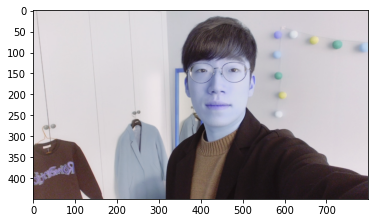

In [39]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러오기
img_show = img_bgr.copy()      # 위 이미지는 이미지를 불러오는 용도이기 때문에 출력용 이미지를 다른 변수에 저장해준다.
plt.imshow(img_bgr)
plt.show()

opencv로 불러온 이미지는 BGR 파일이기 때문에, RGB로 바꾸는 과정이 필요하다.

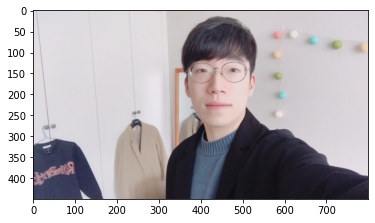

In [3]:
# plt.imshow 
# 이미지 RGB 로 바꾸기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [40]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(345, 98) (531, 284)]]


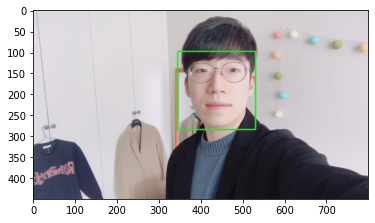

In [6]:
# 찾은 얼굴 영역 박스 리스트
print(dlib_rects)   


for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


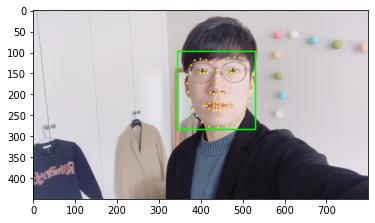

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [11]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


In [12]:
refined_x = x - w // 2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,89)


In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,89)


In [14]:
# 길어서 복잡해 보이지만 img_show[from:to] 형식
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

슝~


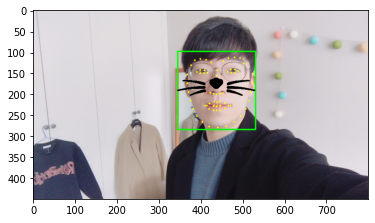

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

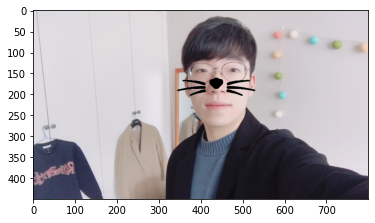

In [16]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

위 샘플 이미지는 모델이 정면을 보고 있었기 때문에 각도에 대한 고려는 크게 하지 않아도 상관없다. <br>
만약 모델의 얼굴이 기울어져 있다면 이를 감지하고 스티커 자체도 회전해야 할것이다. <br>
아래의 코드는 모델의 얼굴이 기울어진 이미지에 대하여, 이를 고려하여 다시 작성한 코드이다.

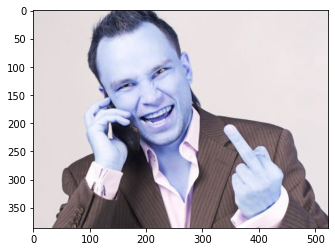

In [17]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/sample.png'
img_bgr = cv2.imread(my_image_path)    
img_show = img_bgr.copy()     
plt.imshow(img_bgr)
plt.show()

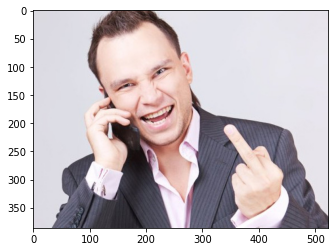

In [18]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

_이미지는 사진을 찾다가 모델의 얼굴이 잘보이면서 고개가 돌아간 것이 너무 적절하여 선정하게 되었다..._

In [19]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [20]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
print("🌫🛸")

🌫🛸


rectangles[[(132, 81) (287, 236)]]


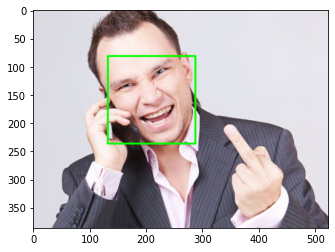

In [21]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [22]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [23]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


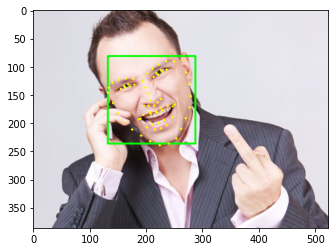

In [24]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Landmark가 모델의 얼굴 각도를 고려하여 표시된 것을 볼 수 있다.

In [25]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(208, 160)
(x,y) : (208,82)
(w,h) : (156,156)


In [26]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


In [27]:
refined_x = x - w // 2
refined_y = y 
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (130,82)


In [28]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (130,82)


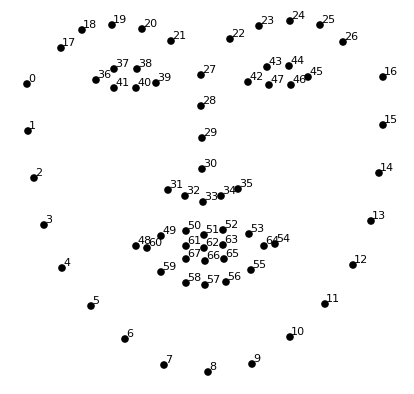

위 랜드마크를 보면 27번 포인트와 코의 정중에 해당하는 30번 포인트를 이은 직선을 이용하여 이미지에 대해서 모델의 얼굴이 얼마나 회전했는지를 계산할 수 있다.<br>
이미지의 세로축과 27번과 30번 포인트를 이은 직선이 이루는 각도를 $\theta$라 하면, 이 $\theta$를 구하는 식은 아래와 같다.
$$
\theta =tan^{-1}{ \frac{x_{30}-x_{27}}{y_{30}-y_{27}}}
$$

위 수식을 풀면 $\theta$는 radian이므로 이를 각도로 변환 하기 위해 $180\over\pi$ 를 곱해주어서 변환할 수 있다.

In [29]:
import math
tan_theta = (landmark[30][0]-landmark[27][0])/(landmark[30][1]-landmark[27][1])
theta = np.arctan(tan_theta)
rotate_angle = theta *180/math.pi
print(rotate_angle)

22.380135051959574


위 과정을 이용해 돌아간 회전 각도가 22.38도임을 알 수 있다.

(156, 156, 3)


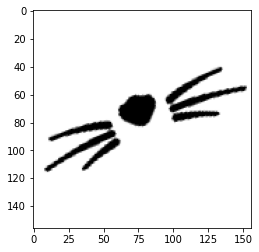

In [30]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

img_rotate = rotate_image(img_sticker,rotate_angle)
print(img_rotate.shape)
plt.imshow(img_rotate)
plt.show()

회전각도에 대하여 회전하는 이미지를 다시 표시하면 위 이미지와 같다.

In [36]:
sticker_area = img_show[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]

img_show[refined_y:refined_y+img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)


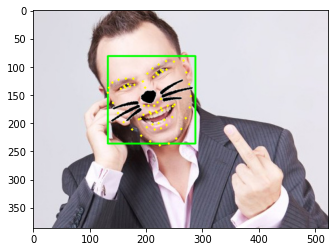

In [37]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

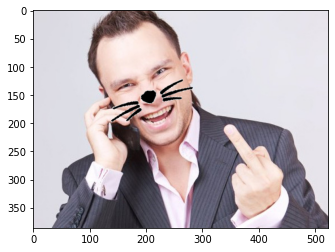

In [38]:
sticker_area = img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]]
img_bgr[refined_y:refined_y +img_rotate.shape[0], refined_x:refined_x+img_rotate.shape[1]] = \
    np.where(img_rotate==255,sticker_area,img_rotate).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

이미지의 스티커가 모델의 얼굴이 회전한만큼 돌아가 적용된 것을 볼 수 있다.

# 회고

## 프로젝트에 대한 평가
<br>
이번 프로젝트에서는 opencv와 dlib을 이용하여 이미지의 모델에 대한 landmark를 찍어 고양이 스티커 사진을 부착하는 프로젝트이다.
<br><br>
처음 코드에 대해서는 모델의 얼굴이 정면을 바라보고 있기 때문에 고개를 기울이는 점에 대해서는 고려하지 않은 코드이지만, 이후 고개를 돌릴 때 고개와 이미지 사이의 각도를 고려하여 스티커를 부착하는 내용을 추가하였다.
<br><br>
다만 단순히 2-D에 대하여 각도를 고려한 것일 뿐, 고개를 끄덕이거나 회전하는 등의 이미지에서는 수염의 모양이 평면적으로 변화하게 될 것인데, 그것에 대해서는 고려하지 못한점이 아쉽다. 또한 인물이 여러명 나오는 사진에 대해서도 테스트를 해 보았는데 해당 코드를 그대로 사용 시, 두 인물에 대한 landmark는 모두 표시되는 것을 확인하였지만, 실제로 스티커가 부착되는 얼굴은 하나 뿐이었다. 다수의 모델이 등장하는 사진에 대해서는 고려하지 못한 코드라는 것이다. 그 이유는 코의 위치를 찾는 for 문을 살펴보면 알 수 있는데, for 문에서 마지막에 인식된 얼굴에 대해서만 x좌표와 y좌표를 저장하기 때문에 그 이전에 인식된 좌표를 저장하지 못하였다. 따라서 해당 문제를 해결하기 위해서는 x좌표와 y좌표를 list 형식으로 만들어 각각의 얼굴에 모두 스티커가 부착이 될 수 있도록 하면 해결할 수 있을 것으로 보인다.

<br><br><br>


## 후기
<br>
처음으로 opencv, dlib을 이용한 프로젝트를 진행하여 어려운점도 있었고 부족한 점도 있었던 것 같다. 평가에서 언급된 문제에 대해서 코딩에 대한 역량과 머신러닝 및 딥러닝에 대한 이해도를 높여 보다 수월하게 프로젝트를 진행할 수 있도록 증진해야겠다는 생각이 든다.


## Reference
<br>
https://velog.io/@dldndyd01/OpenCV-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%EC%A4%91%EC%95%99-%EA%B8%B0%EC%A4%80-%ED%9A%8C%EC%A0%84-cv2.getRotationMatrix2D-%EC%96%BC%EA%B5%B4-%ED%9A%8C%EC%A0%84-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0
<br>

_이미지 모델의 회전에 대한 코드를 참고하였다._